<a href="https://colab.research.google.com/github/hakuchi-1864/Scrape-simple-test-with-Selenium/blob/main/09_SkimLit_npl_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Milestone Projesi: 2

Bu not defterinin amacı tıbbi özetlerin okunmasını daha kolay hale getirmek için bir NLP modeli oluşturmaktır.

Bu çalışmada istifade edeceğimiz tıbbi veri dökümanı: https://arxiv.org/abs/1710.06071

Yukarıdaki linkte yeralan dökümanı okuduğumuzda, en iyi sonuçları elde etmek için kullandıkları model mimarisinin şu linkte mevcut olduğunu görüyoruz:https://arxiv.org/abs/1612.05251

**Kaynak**: Alıştırmamızla ilgili detaylı bilgiler bulmak, nlp kodlarını görmek için: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb



## GPU'ya erişim edin

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-26dcd0f0-7e21-8d2e-2570-5ce8bcf1c91e)


## Veriyi al

PubMed 200k RCT verisini kopyalacağız, onların kullandığı bu veriyi yükleyelim. Github'da veriyi yüklememiz mümkün görünüyor: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


PubMed 200k veri seti olduğu gibi 20k veri setide var. Biz basitten karmaşığa doğru gideceğimizdek 20k ile başlayacağız...Veri bizim için hazırlanmış ve rakamlar yerine @ işareti konulmuş

In [3]:
# PubMed_20k_RCT rakamların "@" ile değiştirildiği veri setini kontrol edelim?
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


dev ML'de validation-değerlendirme verisinin bir başka adıdır

In [4]:
# Versi seti için dizin yolu belirt
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [5]:
data_dir

'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [6]:
# Hedef dizinimizdeki dosyaları kontrol et
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Veriyi ön işleme tabi tut

Verimizi metin olarak aldık şimdi veriye aşina olma zamanı. Veriye aşina olmanın en iyi yöntemlerinden biri görselleştirmektir. Bunu aklımızda tutarak hedef bir dosya metninin her satırını okumak için bir fonksiyon yazacağız

In [7]:
# Bir belgenin satırını okumak için bir fonksiyon yaz
def get_lines(filename):
  """
  Bir metin dosya adını okur ve metnin satırlarını bir liste olarak verir.

  Args:
    filename/dosya adı: hedef dosya yolunu içeren bir stringdir.

  Returns:
    Hedef dosya adından satır başına bir string ile stringler listesi
  """
  with open(filename, "r") as f:
    return f.readlines()

In [8]:
# Eğitim verisindeki satırları oku
train_lines = get_lines(data_dir+"train.txt") # training dizini içinden train.txt metnini oku
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Verimizi nasıl temsil etmek istediğimize bakalım dictionary içeren liste şeklinde düzenleyeceğiz şöyle ki(BACKGROUND örneğinden hareket ediyoruz)

[{ "line_number": 0,

  "target" : "BACKGROUND",

  "text": "Emotional eating is associated with overeating and the development of obesity"

  "total_lines": 11,
  
   .... 
}]

In [10]:
def preprocesses_text_with_line_numbers(filename):
  """
  Özet satır verisinin dictionary listesini verir.

  Bir dosya adını alır, içeriğini okur ve herbir satırı sıralar, hedef etiket, cümle metni, 
  mevcut özette kaç tane cümle var, hedef satırın cümle numarası nedir gibi bilgileri çıkartır.

  """
  
  input_lines = get_lines(filename)  # filename'den/dosya adından tüm satırları al
  abstract_lines = ""   # Boş bir özet oluştur
  abstract_samples = []  # Özetlerin boş bir listesini oluştur

  # Hedef dosyada herbir satırda loop-döngü yap
  for line in input_lines:
    if line.startswith("###"): # (###)ID numarası ile başlayıp başlamadığını kontrol et
      abstract_id = line 
      abstract_lines = "" # eğer ID ile başlıyorsa abstrang stringi reset et

    elif line.isspace(): # satırın yeni bir satır olup olmadığını kontrol et
      abstract_line_split = abstract_lines.splitlines() # özeti ayrı satırlara böl

      # Tek bir özetin her bir satırında döngüye git ve aynı zamanda onları say
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # her bir satır için boş bir dictionary-sözlük oluştur
        target_text_split = abstract_line.split("\t") # hedef etiketi metinden ayır
        line_data["target"] = target_text_split[0] # hedef etiketi al (tab dan önce background 0 ve cümle 1.indeks)
        line_data["text"] = target_text_split[1].lower() # 1.indeksi cümleyi-metni al küçük harfe çevir
        line_data["line_number"] = abstract_line_number # özette görünen satır kaçıncı satıra denk geliyor
        line_data["total_lines"] = len(abstract_line_split)-1 # hedef özette toplam kaç tane satır var(0'dan başlıyoruz)
        abstract_samples.append(line_data) # özet samples liste satır ekler
    else: # yukarıdaki koşullar yerine gelmezse bir satır etiketlendiği cümleyi içerir
      abstract_lines += line # id ve new line ile başlamazsa aradaki tüm satırlarda döngü yap ve bu özetin bir parçasıdır demektir.
  
  return abstract_samples


In [11]:
# dosyadan veri al ve ön işleme tut
%%time
train_samples = preprocesses_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocesses_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocesses_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 570 ms, sys: 93.9 ms, total: 664 ms
Wall time: 800 ms


In [12]:
# Eğitim verimizden ilk 10 satıra bakalım
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Elimizde sözlüklerin listesinden oluşan bir veri setimiz oldu. Daha fazla görselleştirme adına panda veri setine dönüştürelim

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
# Veride dengesizlik var mı bakalım
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

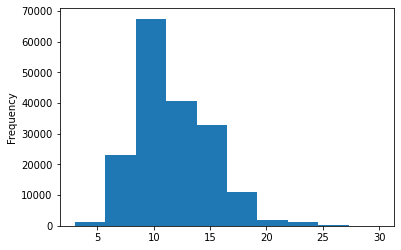

In [15]:
# Farklı satırların uzunluğuna bakalım
train_df.total_lines.plot.hist()

## Cümlelerin listesini al

In [16]:
# özet metinleri listeye dönüştür
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
# Eğitim verisinden ilk 10 cümleyi listeleyelim
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Etiketleri rakama çevirelim(ML sayısal etiketlere ihtiyaç duyar)
One hot code ve label encoded labels oluşturalım. 

Bunun için TensorFlow'un one-hot metodunuda kullanabiliriz. Sklearn'de kullanabiliriz

Rakamsal olarak etiketleme için [OneHotEncoder](https://) ve [LabelEncoder](https://) sınıflarını kullanacağız- SckitLearn'den

In [18]:
# One hot code labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # çünkü tensorflow sparse matriks (ki varsayılan True)ile çalışmaz.
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# One hot encoded label nasıl görünüyor kontrol et
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
# Label encode labels
# Hedef sütündan (target columns) etiketleri al ve integer-sayı haline dönüştür(objective, methods, conclusion, background, results (1-5 rakamları veriyoruz))
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# eğtim seti etiketlerine/training labels bakalım
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# LabelEncoder instance'dan sınıf isimleri ve sayılarını al 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Bir dizi model deneyimlerine başlıyoruz

Olağan olduğu gibi bir dizi farklı modeller deneyimleyeceğiz ve hangisinin en iyi performans verdiğini öğreneceğiz.

En temel olanından baseline modelden (TF-IDF Multinomial Naive Bayes classifer) başlayacağız

## Model 0: TF-IDF Multinomial Naive Bayes Classifier Model

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Pipeline oluştur
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()), # sözcükleri rakama çevirir
  ("clf", MultinomialNB())       # sınıflandırma şekli- kategorisi
])

# Pipeline'ı eğitim verisine uyarla
model_0.fit(X=train_sentences, 
            y=train_labels_encoded); 

In [22]:
# Baseline modeli validation veri seti üzerinden değerlendirelim
model_0.score(X=val_sentences,
              y=val_labels_encoded)


0.7218323844829869

In [23]:
# Baseline modelimizi kullanarak tahmin yapalım
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
# Helper fonksiyonunu yükleyelim
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-28 09:20:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-28 09:20:01 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
# Baseline sonuçlarını hesaplayalım
from helper_functions import calculate_results

In [26]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Deep Sequence Modeller için Verimizi Hazırlayalım

Modellerimizi inşa etmeye başlamadan önce vectorization ve embedding katmanlarını hazırlayacağız.

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
# Ortalama olarak bir cümlenin ne kadar uzunlukta olduğuna bakalım?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
sent_lens

[49,
 27,
 15,
 14,
 35,
 29,
 30,
 55,
 36,
 8,
 32,
 39,
 12,
 26,
 33,
 40,
 22,
 23,
 27,
 26,
 27,
 34,
 41,
 18,
 9,
 23,
 59,
 16,
 18,
 22,
 17,
 51,
 8,
 17,
 16,
 5,
 21,
 4,
 42,
 50,
 11,
 19,
 20,
 29,
 36,
 44,
 39,
 25,
 19,
 24,
 19,
 14,
 11,
 18,
 16,
 26,
 16,
 18,
 38,
 28,
 21,
 18,
 22,
 9,
 37,
 6,
 32,
 21,
 26,
 25,
 18,
 21,
 20,
 12,
 26,
 16,
 23,
 19,
 16,
 39,
 19,
 14,
 37,
 34,
 15,
 47,
 26,
 87,
 17,
 29,
 31,
 13,
 37,
 28,
 35,
 60,
 64,
 66,
 8,
 12,
 17,
 40,
 43,
 37,
 47,
 6,
 40,
 64,
 20,
 32,
 53,
 16,
 30,
 54,
 51,
 19,
 28,
 32,
 36,
 40,
 13,
 25,
 30,
 23,
 17,
 15,
 20,
 50,
 12,
 16,
 27,
 24,
 10,
 24,
 5,
 14,
 19,
 32,
 13,
 21,
 23,
 10,
 11,
 17,
 12,
 21,
 21,
 15,
 17,
 21,
 18,
 40,
 33,
 21,
 41,
 21,
 13,
 29,
 28,
 13,
 44,
 20,
 31,
 8,
 29,
 13,
 116,
 27,
 26,
 32,
 34,
 17,
 23,
 20,
 29,
 11,
 7,
 17,
 31,
 43,
 36,
 17,
 31,
 17,
 42,
 18,
 39,
 29,
 30,
 24,
 81,
 19,
 19,
 33,
 22,
 11,
 55,
 11,
 14,
 28,
 42,
 34,
 

In [29]:
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

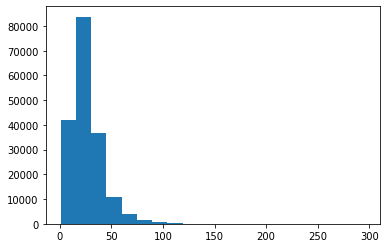

In [30]:
# Verilerin dağıtımına bakalım
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)


### Tokenimiz-vectorizer ederken istatistikten %95 oranında verimizi cümlelerin uzunluğunu neyin temsil ettiğini bulacağız. Böylece verimizi işlerken baz alacağımız uzunluğu bulacağız

In [31]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# eğitim verimizdeki maksimum cümle uzunluğuna bakalım
max(sent_lens), min(sent_lens)

(296, 1)

## Text Vectorizer katmanı oluşturmak
Metinleri sözcüklerden numaralara map edecek bir katman oluşturmak istiyoruz

In [33]:
# Vocab- Sözlüğümüz içinde kaç tane sözcük vardır? (https://arxiv.org/pdf/1710.06071.pdf tablo 2'den alındı)
max_tokens = 68000

In [34]:
# Text vectorizer oluşturalım
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens, # sözlükteki sözcüklerin sayısı
                                    output_sequence_length=output_seq_len) # vektör halinde dizelerimizin arzu edilen uzunluğu

In [35]:
# Text vectorizer oluşturduktan sonra eğitim verimize adapt etmek durumundayız
text_vectorizer.adapt(train_sentences)

In [36]:
# Rastgele cümleler üzerinde text vectorizer'ımızı test edelim
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\n Vectorized text: {text_vectorizer([target_sentence])}")

Text:
data were analyzed with one-way ancova with delta scores and pre and post-training tests raw scores .

Length of text: 17

 Vectorized text: [[ 100    9  384    7 5421 4396    7 6217  119    3 1093    3 5259  549
  5253  119    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [37]:
# Eğitim verisi sözlüğünde kaç tane sözcüğümüz var(68k'dan biraz düşük çıkacak, numaraların @ harfine çevrildiğinden dolayı)
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in the vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in the vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Text vectorizer ile ilgili bilgi alalım
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [39]:
# Token embedding(gömülü sözcük)katmanı oluşturalım
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # sözlük uzunluğu
                               output_dim = 128, # farklı embedding boyutları eğitilebilir parametrelerin sayısı üzerinde ciddi etkisi vardır
                               mask_zero= True, # farklı uzunluktaki değişkenlerin (0'lar) hesabı için kullanışlıdır
                               name="token_embedding")


In [40]:
# Embedding örneği gösterelim
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")


Sentence before vectorization:
 data were analyzed with one-way ancova with delta scores and pre and post-training tests raw scores .

Sentence after vectorization (before embedding):
 [[ 100    9  384    7 5421 4396    7 6217  119    3 1093    3 5259  549
  5253  119    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.00214468 -0.00226754  0.02466672 ... -0.00163202  0.03201479
    0.02329613]
  [-0.04885211 -0.04213249  0.0065297  ... -0.03428657  0.01284846
   -0.03770842]
  [ 0.01519739 -0.02031808  0.00511676 ... -0.04641659  0.00431465
    0.00998924]
  ...
  [ 0.01319901  0.04883193  0.0233002  ... -0.0284758  -0.03419082
   -0.04130503]
  [ 0.01319901  0.04883193  0.0233002  ... -0.0284758  -0.03419082
   -0.04130503]
  [ 0.01319901  0.04883193  0.0233002  ... -0.0284758  -0.03419082
   -0.04130503

Embedded sentence shape: (1, 55, 128)

1= the mean t@/@ of krn@ was @-@ days after i.v. administration and @-@ days after s.c. administration  => bir cümle demek

55 = Bu dizedeki sözcüklerin sayısı

128 = Her bir sözcük 128 vektör boyuttan oluşur

## Mümkün olduğunca hızlı bir şekilde yükleyebileceğimiz verisetimizi oluşturalım
TensorFlow tf.data API ile mümkün olduğunca hızlı çalışacak şekilde verimizi kuracağız, burada atacağımız adımlarla ilgili geniş bilgi almak için: https://www.tensorflow.org/guide/data_performance ve https://www.tensorflow.org/guide/data

In [41]:
# Verisetimizi TensorFlow tarafından daha hızlı işlenmesi için verimizi TensorFlow Datasets haline çevireceğiz
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [42]:
len(train_dataset)

180040

In [43]:
# TensorSliceDataset'i alıp prefetched dataseti haline çevirelim
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)# kaç tane örneğin işleneceğine otomatik olarak karar ver, shuffled yapmıyoruz çünkü veride sıra önemli
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D 

In [44]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [45]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [46]:
len(train_dataset)

5627

In [47]:
5627*32

180064

epoch başına 562 veriyi batch ediyor

Verimizi daha hızlı eğitip geliştirmek için veri setimizin yüzde 10'nu eğiteceğiz. 

In [48]:
history_model_1 = model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=val_dataset,
                            validation_steps=0.1*len(val_dataset))

Epoch 1/3
562/562 [==============================] - 14s 9ms/step - loss: 0.8274 - accuracy: 0.6874 - val_loss: 0.5957 - val_accuracy: 0.7750
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.5788 - accuracy: 0.7858 - val_loss: 0.5530 - val_accuracy: 0.7951
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.5474 - accuracy: 0.7987 - val_loss: 0.5247 - val_accuracy: 0.8036


In [49]:
# Tüm veri seti üzerinde değerlendirelim
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5237 - accuracy: 0.8042


[0.5236868858337402, 0.8042168617248535]

In [50]:
# Tahminler yapalım ki modelimiz herbir sınıf(5 sınıfımız var) için tahmin olasılığı değeri tahmini yapar
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[5.5529696e-01, 1.3601279e-01, 4.2235455e-03, 3.0068141e-01,
         3.7852474e-03],
        [4.0659299e-01, 4.0709722e-01, 1.1881454e-03, 1.8268462e-01,
         2.4370118e-03],
        [1.1601725e-01, 1.0494714e-02, 1.9759021e-03, 8.7132770e-01,
         1.8447201e-04],
        ...,
        [2.0447948e-04, 2.3144623e-03, 2.3579644e-02, 2.3886113e-04,
         9.7366256e-01],
        [2.0805230e-02, 4.3660563e-01, 4.5964420e-02, 1.9784415e-02,
         4.7684026e-01],
        [2.8947875e-02, 9.5417321e-01, 1.6649672e-03, 3.6323762e-03,
         1.1581541e-02]], dtype=float32), (30212, 5))

In [51]:
# Pred probs'ları sınıflara dönüştürelim(maksimum değerini alacağız- ilgili sınıfına (5 tane)çevireceğiz)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [52]:
# Model_1 sonuçlarını hesaplayalım
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.42168674698796,
 'precision': 0.8023749213904764,
 'recall': 0.8042168674698795,
 'f1': 0.8024117111871234}

In [53]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Önceden eğitime tutulmuş gömülü sözcük özellik çıkarımı

In [54]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [55]:
# Rastgele bir cümle üzerinde eğitime tutulmuş bu katmanı test edelim
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
qva@ , when compared with placebo , showed the time-matched largest mean increase and decrease in hr of @ bpm and -@ bpm , respectively , and average hr change from baseline of @ bpm .

Sentence after embedding:
[-0.00908535  0.04744115  0.04734941 -0.0230239  -0.06096454  0.03216852
 -0.00269799 -0.02545223  0.05541492  0.06838799  0.05831067 -0.05057122
 -0.0560799  -0.04457495  0.02133318 -0.00179604 -0.07213023 -0.0485524
  0.0117375  -0.00589799 -0.00920447  0.03038701 -0.05120008  0.04659907
 -0.06120548  0.04619487 -0.06452386  0.06252629 -0.07119336 -0.04345678] (truncated output)...

Length of sentence embedding:
512


## TensorFlow Hub'dan NLP feature extraction model kuralım ve derleyelim

In [56]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_feature_extraction")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
model_2.summary()

Model: "model_2_feature_extraction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [58]:
history_model_2 = model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=val_dataset,
            validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9170 - accuracy: 0.6489 - val_loss: 0.7976 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 9s 17ms/step - loss: 0.7685 - accuracy: 0.7023 - val_loss: 0.7555 - val_accuracy: 0.7035
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7502 - accuracy: 0.7131 - val_loss: 0.7384 - val_accuracy: 0.7121


In [59]:
# Tüm veri seti üzerinde değerlendirelim
model_2.evaluate(val_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7401 - accuracy: 0.7136


[0.7400967478752136, 0.7135575413703918]

In [60]:
# Tahminler yapalım ki modelimiz herbir sınıf(5 sınıfımız var) için tahmin olasılığı değeri tahmini yapar
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs, model_2_pred_probs.shape

945/945 [==============================] - 10s 10ms/step


(array([[0.46845496, 0.361289  , 0.0023961 , 0.15880491, 0.00905502],
        [0.33850503, 0.5038541 , 0.0045569 , 0.14907107, 0.00401296],
        [0.23950526, 0.14396377, 0.01596723, 0.56460065, 0.03596306],
        ...,
        [0.00208692, 0.00632482, 0.05622237, 0.00095069, 0.9344152 ],
        [0.00384556, 0.04637625, 0.19769873, 0.00154157, 0.75053793],
        [0.19719438, 0.24248338, 0.48542506, 0.00618839, 0.06870881]],
       dtype=float32), (30212, 5))

In [61]:
# Pred probs'ları sınıflara dönüştürelim(maksimum değerini alacağız- ilgili sınıfına (5 tane)çevireceğiz)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [62]:
# Model_2 sonuçlarını hesaplayalım
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.35575268105389,
 'precision': 0.713773915259621,
 'recall': 0.7135575268105389,
 'f1': 0.7107430878265201}

## Model 3: Karakter embeddings ile Conv1D

Tekrarladığımız resmi belgede token(her bir farklı sözcüğü kod haline getirme) ve character(karakter-harf) embeddings birleşimi kullanıldığından. Biz de karakter gömülü işlevini gerçekleştireceğiz

### Karakter-level tokenizer oluşturma

In [63]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [64]:
list(train_sentences[0])

['t',
 'o',
 ' ',
 'i',
 'n',
 'v',
 'e',
 's',
 't',
 'i',
 'g',
 'a',
 't',
 'e',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'e',
 'f',
 'f',
 'i',
 'c',
 'a',
 'c',
 'y',
 ' ',
 'o',
 'f',
 ' ',
 '@',
 ' ',
 'w',
 'e',
 'e',
 'k',
 's',
 ' ',
 'o',
 'f',
 ' ',
 'd',
 'a',
 'i',
 'l',
 'y',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'd',
 'o',
 's',
 'e',
 ' ',
 'o',
 'r',
 'a',
 'l',
 ' ',
 'p',
 'r',
 'e',
 'd',
 'n',
 'i',
 's',
 'o',
 'l',
 'o',
 'n',
 'e',
 ' ',
 'i',
 'n',
 ' ',
 'i',
 'm',
 'p',
 'r',
 'o',
 'v',
 'i',
 'n',
 'g',
 ' ',
 'p',
 'a',
 'i',
 'n',
 ' ',
 ',',
 ' ',
 'm',
 'o',
 'b',
 'i',
 'l',
 'i',
 't',
 'y',
 ' ',
 ',',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 's',
 'y',
 's',
 't',
 'e',
 'm',
 'i',
 'c',
 ' ',
 'l',
 'o',
 'w',
 '-',
 'g',
 'r',
 'a',
 'd',
 'e',
 ' ',
 'i',
 'n',
 'f',
 'l',
 'a',
 'm',
 'm',
 'a',
 't',
 'i',
 'o',
 'n',
 ' ',
 'i',
 'n',
 ' ',
 't',
 'h',
 'e',
 ' ',
 's',
 'h',
 'o',
 'r',
 't',
 ' ',
 't',
 'e',
 'r',
 'm',
 ' ',
 'a',
 'n',
 'd',
 ' ',
 'w',
 'h',
 'e'

In [65]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [66]:
# Bir cümleyi karakterlere ayıracak bir fonksiyon yazalım
def split_chars(text):
  return " ".join(list(text))

In [67]:
# Test edelim
split_chars(random_training_sentence)

'q v a @   ,   w h e n   c o m p a r e d   w i t h   p l a c e b o   ,   s h o w e d   t h e   t i m e - m a t c h e d   l a r g e s t   m e a n   i n c r e a s e   a n d   d e c r e a s e   i n   h r   o f   @   b p m   a n d   - @   b p m   ,   r e s p e c t i v e l y   ,   a n d   a v e r a g e   h r   c h a n g e   f r o m   b a s e l i n e   o f   @   b p m   .'

In [68]:
# Dizi-seviyeside split ettiğimiz verimizi, karakter seviyesinde split yapalım
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [69]:
# Ortalama karakter dizi uzunluğu nedir?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <a list of 20 Patch objects>)

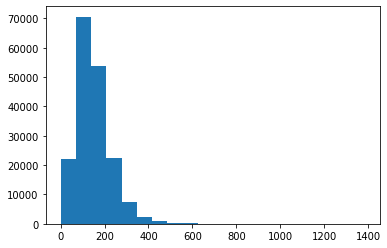

In [70]:
# Karakter dizelerinin dağılımına bakalım
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20)

In [71]:
# Verinin %95'ine ne denk geliyor?
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [72]:
# Keyboard'da yer alan tüm karakterleri görelim
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [73]:
# Char-level token vectorizer instance oluşturalım
NUM_CHAR_TOKENS = len(alphabet) + 2 # space ve OOV veya [UNK] out of vocabulary veya unknown için (+2)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    #standardize=None, # eğer noktalama işaretlerini de eklemek istiyorsanız None yapın.
                                    name="char_vectorizer")


In [74]:
# Training charactere(eğitim karakteri) adapte edelim
char_vectorizer.adapt(train_chars)

In [75]:
# Character vocab durumuna bakalım
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least characters: ['k', 'x', 'z', 'q', 'j']


In [76]:
# Test edelim
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of random_train_chars:{len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized_chars:\n{len(vectorized_chars[0])}")

Charified text:
i n   g r o u p   a   ,   d u r a l   p u n c t u r e   w a s   p e r f o r m e d   w i t h   t h e   p a t i e n t   i n   a   s e a t e d   p o s i t i o n   u s i n g   @   c m   (   @   )   o f   h y p e r b a r i c   b u p i v a c a i n e   .

Length of random_train_chars:100

Vectorized chars:
[[ 4  6 18  8  7 16 14  5 10 16  8  5 12 14 16  6 11  3 16  8  2 20  5  9
  14  2  8 17  7  8 15  2 10 20  4  3 13  3 13  2 14  5  3  4  2  6  3  4
   6  5  9  2  5  3  2 10 14  7  9  4  3  4  7  6 16  9  4  6 18 11 15  7
  17 13 19 14  2  8 22  5  8  4 11 22 16 14  4 21  5 11  5  4  6  2  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0 

Charified text:
p r o c e s s   e v a l u a t i o n   w i l l   i n c l u d e   a n a l y s i s   o f   r e c o r d e d   s u p p o r t   s e s s i o n s   a n d   p a t i e n t   a n d   p r a c t i t i o n e r   i n t e r v i e w s   .

Length of random_train_chars:221

Vectorized chars:
[[14  8  7 11  2  9  9  2 21  5 12 16  5  3  4  7  6 20  4 12 12  4  6 11
  12 16 10  2  5  6  5 12 19  9  4  9  7 17  8  2 11  7  8 10  2 10  9 16
  14 14  7  8  3  9  2  9  9  4  7  6  9  5  6 10 14  5  3  4  2  6  3  5
   6 10 14  8  5 11  3  4  3  4  7  6  2  8  4  6  3  2  8 21  4  2 20  9
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]

Length of vectorized_chars:
1

## Karakter level embedding oluşturalım

In [77]:
# Char embedding oluşturalım
char_embed = layers.Embedding(input_dim=len(char_vocab), #farklı karakterlerin sayısı
                              output_dim=25, # replika ettiğimiz belgede belirtilen boyutun sayısı
                              mask_zero=True,
                              name="char_embed")

In [78]:
# Test edelim
print(f"Charified text:\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embeddings):\n{char_embed_example}")
print(f"Character embedding shape:{char_embed_example.shape}")

Charified text:
i n   g r o u p   a   ,   d u r a l   p u n c t u r e   w a s   p e r f o r m e d   w i t h   t h e   p a t i e n t   i n   a   s e a t e d   p o s i t i o n   u s i n g   @   c m   (   @   )   o f   h y p e r b a r i c   b u p i v a c a i n e   .

Embedded chars. (after vectorization and embeddings):
[[[ 0.04658845  0.04339775  0.00309879 ...  0.04895706 -0.03141639
   -0.02435648]
  [ 0.04791894  0.01588012  0.02576364 ... -0.02382869 -0.04465898
   -0.0484157 ]
  [-0.04880655  0.0143127   0.04814882 ...  0.01608658  0.01263348
   -0.02336793]
  ...
  [-0.01767911 -0.01563913  0.02640228 ...  0.02672948  0.0317854
   -0.04425482]
  [-0.01767911 -0.01563913  0.02640228 ...  0.02672948  0.0317854
   -0.04425482]
  [-0.01767911 -0.01563913  0.02640228 ...  0.02672948  0.0317854
   -0.04425482]]]
Character embedding shape:(1, 290, 25)


In [79]:
len(random_train_chars)

247

## Character embeddinge uyarlamak üzere bir Conv1D Modeli oluşturalım

In [80]:
# Sadece karakter embedding bir Conv1D oluşturalım
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1d_char_embeddings")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [81]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 

In [82]:
# Char level dataseti oluşturalım(hızlı yüklemek için)
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset


<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [83]:
# Sadece karakter embedding olarak ayaralayalım
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2871 - accuracy: 0.4723 - val_loss: 1.0613 - val_accuracy: 0.5691
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0188 - accuracy: 0.5921 - val_loss: 0.9547 - val_accuracy: 0.6260
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9349 - accuracy: 0.6282 - val_loss: 0.8764 - val_accuracy: 0.6626


In [84]:
# Tüm veri seti üzerinde değerlendirelim
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.9011 - accuracy: 0.6505


[0.9011401534080505, 0.6505030989646912]

In [85]:
# Tahminler yapalım
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs, model_3_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[0.14604148, 0.24010482, 0.153176  , 0.40704775, 0.05362993],
        [0.28359982, 0.3444134 , 0.03956822, 0.23843043, 0.09398819],
        [0.07339423, 0.19705957, 0.26910648, 0.3003886 , 0.1600511 ],
        ...,
        [0.01986482, 0.02721312, 0.15255818, 0.04518572, 0.75517815],
        [0.05836906, 0.3444887 , 0.28967604, 0.05162423, 0.2558419 ],
        [0.26581022, 0.3827059 , 0.23963778, 0.09437615, 0.01746985]],
       dtype=float32), (30212, 5))

In [86]:
# Model pred_probsu sınıf etiketlerine dönüştürelim
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 1, 1])>

In [87]:
# Sonuçları hesaplayalım
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.05031113464848,
 'precision': 0.6458104019975343,
 'recall': 0.6505031113464849,
 'f1': 0.6407435414191045}

## Model 4: Önceden eğitilmiş gömülü sözcük + gömülü karakter(gömülü hibrid katmanı)birleşimi

1. Gömülü sözcük modeli(token_embedding) model_2 benzer- oluştur
2. Model 3'e benzer biraz farklı gömülü karakter(character_embedding) modeli oluştur
3. 1 ve 2. maddeleri birleştir(layers.Concatenate)
4. Figure 1 ve Bölüm 4.2'ye https://arxiv.org/pdf/1612.05251.pdf benzer bir dizi çıktı katmanları oluştur
5. Sözcük ve karakter seviyede dizeleri girdi olarak alacak ve etiket tahmin olasılıklarını çıktı olarak verecek bir model kur

Sequential API bir sıra halinde gider.

Functional API farklı adımları birleştirmede kullanılır.

In [88]:
#1. Sözcük girdileri/modeli hazırla
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

#2. Karakter girdileri/modeli hazırla
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # hidden birim 25 sayısı resmi belgeden geldi
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

#3. Token ve char girdilerini concatenate-birleştirme işlemi yapacağız(token ve char outputlarını biraraya getirmek)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

#4. Dropout eklenmiş çıktı katmanları oluşturacağız resmi belge 4.2 ye uygun
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

#5. Sözcük ve karakter girdileri ile model oluşturalım
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [89]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

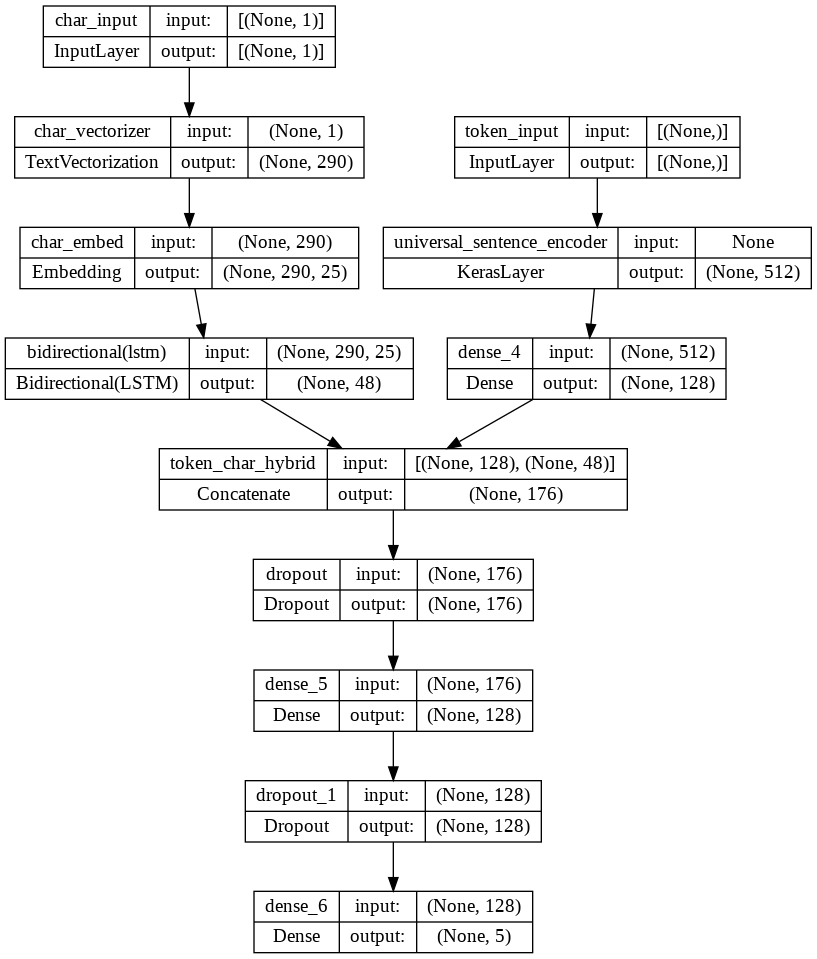

In [90]:
# Sözcük ve karakter hibrid modelimizi birbaşka yolla görselleştirelim
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [91]:
# Derleyelim
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Sözcük ve karakter verimizi tf.data Dataset-Prefetch çevireceğiz ki hızlı yüklenip çalışsın


In [92]:
# Chars ve token verilerini datasette birleştirelim
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # veri yapar
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # etiket yapar
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # veri ve etiketi birleştirir

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # veri yapar
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # etiket yapar
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # veri ve etiketi birleştiri

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars)) # veri yapar
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) # etiket yapar
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels)) # veri ve etiketi birleştiri

# Verileri prefetch ve batch edelim
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [93]:
# Data ve Validation veri setlerimizi kontrol edelim
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [94]:
# Modelimizi uyarlayalım-fit edelim
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 53ms/step - loss: 0.9840 - accuracy: 0.6094 - val_loss: 0.7721 - val_accuracy: 0.6998
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.8018 - accuracy: 0.6950 - val_loss: 0.7114 - val_accuracy: 0.7231
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7697 - accuracy: 0.7048 - val_loss: 0.6880 - val_accuracy: 0.7410


In [95]:
# Modeli değerlendirelim
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 23ms/step - loss: 0.6946 - accuracy: 0.7345


[0.6945696473121643, 0.7344763875007629]

In [96]:
# Tahminler yapalım
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 23s 22ms/step


array([[4.3832359e-01, 3.3961993e-01, 3.1709524e-03, 2.1345785e-01,
        5.4276134e-03],
       [3.4591186e-01, 3.7476981e-01, 2.4281896e-03, 2.7489254e-01,
        1.9976469e-03],
       [3.0979481e-01, 1.1788796e-01, 3.6908787e-02, 5.0883734e-01,
        2.6571121e-02],
       ...,
       [5.1860040e-04, 6.0471240e-03, 5.7418983e-02, 2.4954701e-04,
        9.3576568e-01],
       [5.3583025e-03, 5.9590362e-02, 2.8391096e-01, 2.3586494e-03,
        6.4878178e-01],
       [2.4331674e-01, 3.5938558e-01, 3.0957592e-01, 2.2194166e-02,
        6.5527558e-02]], dtype=float32)

In [97]:
# Tahmin etiketleri sınıfına dönüştürelim
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [98]:
# Sonuçlarına bakalım
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.44763670064874,
 'precision': 0.7360020103971788,
 'recall': 0.7344763670064874,
 'f1': 0.732142654617879}

## Model 5: Önceden eğitime tabi tutulan gömülü sözcük + gömülü harf + gömülü pozisyonel ile transfer eğitimi

In [99]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


**Not:** Bir modeli eğitmek için kullanılan herhangi bir mühendislik özelliğinin test sırasında mevcut olması gerekir. Bizim durumumuzda satır(cümle numarası) ve toplam satır sayıcı mevcuttur. Veriyi önişleme tabii tuttuğumuz başlangıçta oluşturmuştuk.

### Gömülü pozisyonal(positional embeddings) oluşturmak

In [100]:
# Kaç tane farklı satır numarası vardır?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

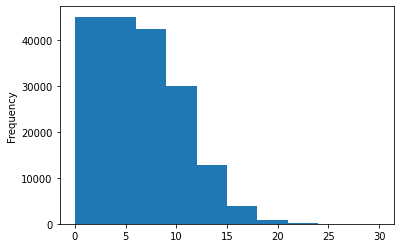

In [101]:
# Satır sayıları ile ilgili sütunların dağıtımına bakalım
train_df.line_number.plot.hist()

In [102]:
# Bu sefer line_number sütunumuzdan TensorFlow kullanarak one hot encoded tensörler oluşturacağız(daha önce sklearn ile yapmıştık)
train_one_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15) #depth percentile olarak bulduğumuz veriyi doğrudan hist. belirledik.
train_one_line_numbers_one_hot[:14], train_one_line_numbers_one_hot.shape
val_one_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_one_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)


In [103]:
# Kaç farklı toplam satır sayısı vardır?
train_df.total_lines.value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

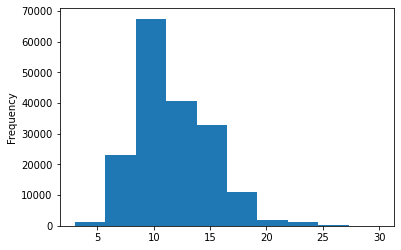

In [104]:
# Toplam satır sayıları ile ilgili sütunların dağıtımına bakalım
train_df.total_lines.plot.hist()

In [105]:
# Percentile ile ortalamayı bulalım
np.percentile(train_df.total_lines, 95)

18.0

In [106]:
# Bu sefer line_number sütunumuzdan TensorFlow kullanarak one hot encoded tensörler oluşturacağız(daha önce sklearn ile yapmıştık)
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20) #depth percentile olarak bulduğumuz veriyi doğrudan hist. belirledik.
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:14], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(14, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Gömülü tri-hibrid model oluşturma safhalarımız

1. Gömülü sözcük modeli(token embedding) oluştur
2. Gömülü karakter modeli(char embedding) oluştur
3. "line_number" özelliği için bir model oluştur
4. "total_lines" özelliği için bir model oluştur
5. tf.keras.layers.Concatenate kullanarak 1 ve 2'nin çıktılarını biraraya getir
6. tf.keras.layer.Cocatenate kullanarak 3,4 ve 5'in çıktılarını biraraya getir
7. Üç gömülü hibrid katmanı kabul edecek bir çıktı katmanı oluştur ve çıktı etiket olasılıklarını oluştur
8. 1,2,3,4'ün girdileri ile 7'nin çıktısını tf.keras.Model de birleştir 

In [107]:
# 1. Token inputs (Sözcük girdileri)
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs(karakter girdileri)oluştur
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line number feature model
line_number_feature_inputs = layers.Input(shape=(15, ), dtype=tf.float32, name="line_number_feature_input")
x = layers.Dense(32, activation="relu")(line_number_feature_inputs)
line_number_feature_model = tf.keras.Model(inputs=line_number_feature_inputs,
                                            outputs=x)

# 4. Total lines feature model
total_lines_feature_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_feature_input")
y = layers.Dense(32, activation="relu")(total_lines_feature_inputs)
total_lines_feature_model = tf.keras.Model(inputs=total_lines_feature_inputs,
                                           outputs=y)

# 5. Token ve char embeddings hybrid embedding içinde biraraya getirelim
combined_char_token_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                                          char_model.output])

z = layers.Dense(256, activation="relu")(combined_char_token_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Token ve char embeddings ile pozitional embeddingsi bir araya getirelim
trihybrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_feature_model.output,
                                                                                   total_lines_feature_model.output,
                                                                                   z])
# 7. Output layer oluştur
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(trihybrid_embeddings)

# 8. Tüm girdiler ile çıktıyı birleştirip modelimizi oluşturalım
model_5 = tf.keras.Model(inputs=[line_number_feature_model.input,
                                 total_lines_feature_model.input,
                                 token_model.input,
                                 char_model.input], outputs=output_layer, name="model_5_trihybrid_embedding_model")

In [108]:
model_5.summary()

Model: "model_5_trihybrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

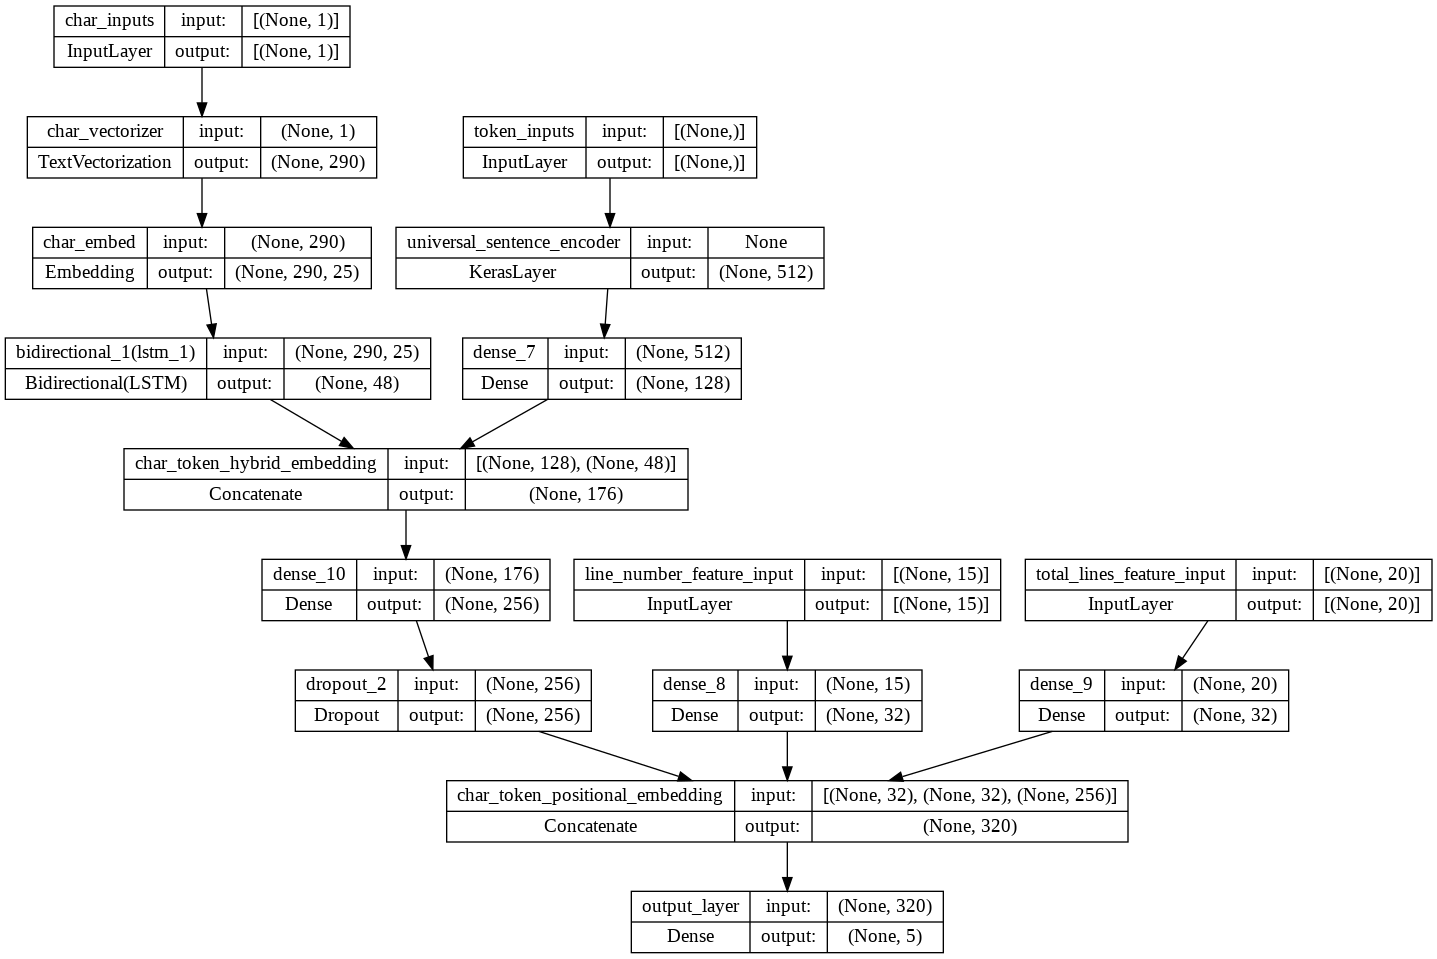

In [109]:
# Sözcük ve karakter ve pzisyonel tri_hibrid modelimizi birbaşka yolla görselleştirelim
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

Label smoothing nedir?

Örneğin, modelimiz tek bir sınıf üzerinde aşırı emin olursa, ya da tahmin olasılığı çok yüksek ise sadece bu sınıfa takılı kalıp diğer sınıfları dikkate almayabilir [0.0, 0.0, 1.0, 0.0, 0.0] gibi.

label smoothing işlevinin yaptığı şey en yüksek tahmin değerinden bazı sayıları diğer sınıflara vererek overfitting probleminin önüne geçerek genelleşmeyi geliştirmesi umulur. [0.01, 0.01, 0.96, 0.01, 0.01]

daha fazla bilgi almak için kaynak: https://pyimagesearch.com/

In [110]:
# Modeli derleyelim
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
                

## Sözcük,karakter, pozisyonel verimizi tf.data Dataset-Prefetch çevireceğiz ki hızlı yüklenip çalışsın

In [111]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_one_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars)) #model_5'i korduğumuz sırada sıraladık.

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_one_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars)) #model_5'i korduğumuz sırada sıraladık.

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_one_line_numbers_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars)) #model_5'i korduğumuz sırada sıraladık.

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [112]:
# input shape kontrol edelim
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [113]:
# Modeli uyarlayalım-fit edelim
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 53ms/step - loss: 1.0994 - accuracy: 0.7223 - val_loss: 0.9831 - val_accuracy: 0.8005
Epoch 2/3
562/562 [==============================] - 30s 53ms/step - loss: 0.9689 - accuracy: 0.8138 - val_loss: 0.9517 - val_accuracy: 0.8261
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.9516 - accuracy: 0.8213 - val_loss: 0.9397 - val_accuracy: 0.8288


In [114]:
# Modelimizle tahmin yapalım
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 24s 22ms/step


array([[0.46077445, 0.11739905, 0.01158971, 0.39311978, 0.01711694],
       [0.555538  , 0.09220067, 0.04647565, 0.29451394, 0.01127165],
       [0.28938645, 0.10498933, 0.12862262, 0.41226664, 0.06473491],
       ...,
       [0.03743133, 0.09703309, 0.05057306, 0.03413321, 0.7808293 ],
       [0.03147852, 0.26249003, 0.06760534, 0.02595231, 0.61247385],
       [0.16587104, 0.63497734, 0.10016711, 0.03209331, 0.06689121]],
      dtype=float32)

In [115]:
# Pred probs'u pred labels'e çevir
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [116]:
# Sonuçları hesaplayalım
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.10274063286111,
 'precision': 0.8299692654992448,
 'recall': 0.8310274063286112,
 'f1': 0.8298894743334096}

## Model sonuçlarını karşılaştıralım

In [117]:
# Panda veri setini kullanarak yapalım
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embed_conv1d": model_1_results,
                                  "model_2_pretrained_token_embed": model_2_results,
                                  "model_3_custom_char_embed_conv1d": model_3_results,
                                  "model_4_hybrid_char_token_embed": model_4_results,
                                  "model_5_trihybrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embed_conv1d,80.421687,0.802375,0.804217,0.802412
model_2_pretrained_token_embed,71.355753,0.713774,0.713558,0.710743
model_3_custom_char_embed_conv1d,65.050311,0.645810,0.650503,0.640744
model_4_hybrid_char_token_embed,73.447637,0.736002,0.734476,0.732143
model_5_trihybrid_pos_char_token_embed,83.102741,0.829969,0.831027,0.829889


In [118]:
# Accuracy değerini diğer rakamlara uygun hale getirelim ve tüm sonuçları görselleştirelim
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embed_conv1d,0.804217,0.802375,0.804217,0.802412
model_2_pretrained_token_embed,0.713558,0.713774,0.713558,0.710743
model_3_custom_char_embed_conv1d,0.650503,0.645810,0.650503,0.640744
model_4_hybrid_char_token_embed,0.734476,0.736002,0.734476,0.732143
model_5_trihybrid_pos_char_token_embed,0.831027,0.829969,0.831027,0.829889


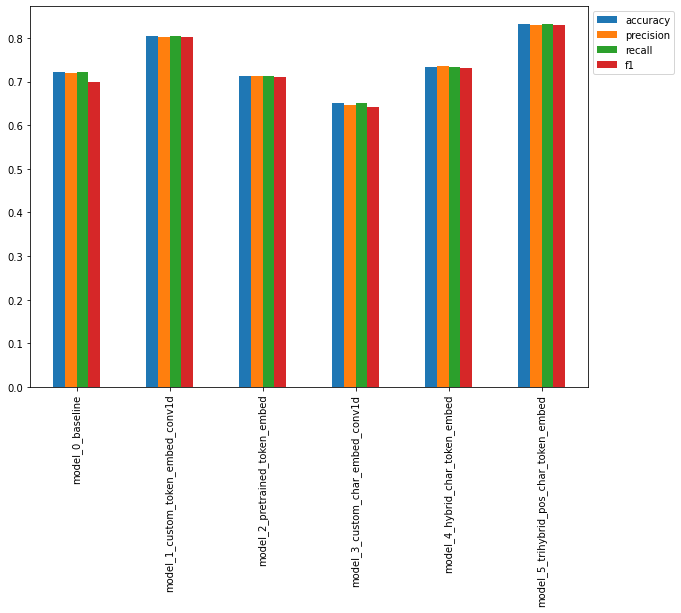

In [119]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

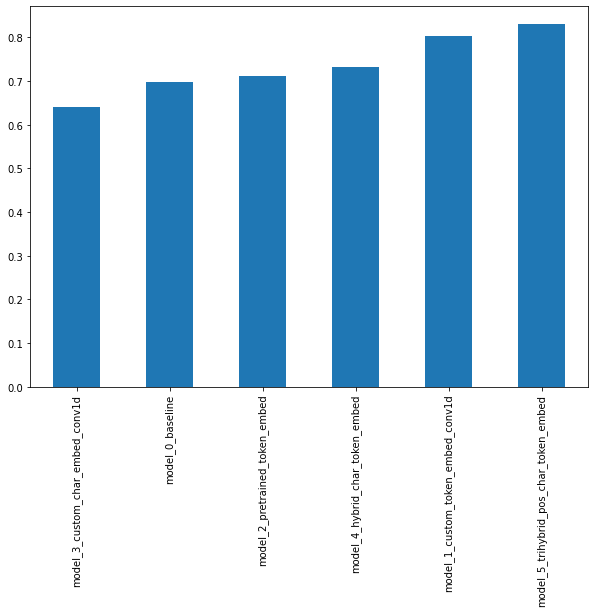

In [120]:
# f-1 skorlarına göre görselleştirelim
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

## Modeli kaydet ve yükle

In [121]:
# En iyi performans gösteren modeli SavedModel ile kaydedelim
#model_5.save("skimlit_trihybrid_model")

In [122]:
# Yükleyelim
#loaded_model = tf.keras.models.load_model("skimlit_trihybrid_model")

In [123]:
# Loaded model ile tahminler yapalım
#loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
#loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
#loaded_preds[:10]

In [124]:
# Sonuçlarına bakalım
#loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                        # y_pred=loaded_preds)
#loaded_model_results

IndentationError: ignored

In [ ]:
#assert model_5_results == loaded_model_results # çalışmazsa hata verecekti

In [ ]:
#loaded_model.summary()

## Alıştırmalar

1. Test veri örneklerini tf.data.Dataset'e çevir ve onlar üstünde en iyi performans veren modelle değerlendirme (tahmin)yap
2. 1'den en yanlış tahmini bul(yüksek tahmin değeri ile yanlış etiket tahminleri yapan örneklerdir)
3. Örneklerden tahminler yapın. (ham rct özetlerine bak) https://pubmed.ncbi.nlm.nih.gov/ (rct ile arama ya- metabolism rct gibi). 3-4 tane örnek bul modelle tahminler yap.
4. Alıştırmalar bölümünde olan ekstra görevleri yerine getir..

In [125]:
# Tüm veri seti üzerinde değerlendirelim
model_5.evaluate(test_char_token_pos_dataset)

942/942 [==============================] - 22s 23ms/step - loss: 0.9468 - accuracy: 0.8267


[0.9467555284500122, 0.8267462849617004]

In [126]:
# Loaded Model'imizle test verisi üzerinde tahminler yapalım
test_pred_probs = model_5.predict(test_char_token_pos_dataset)
test_pred_probs

942/942 [==============================] - 23s 24ms/step


array([[0.34249136, 0.07363743, 0.0424303 , 0.48171622, 0.05972468],
       [0.35412577, 0.0599063 , 0.23043136, 0.31293467, 0.04260197],
       [0.07720678, 0.0230058 , 0.75707906, 0.09536823, 0.04734005],
       ...,
       [0.08588167, 0.08560443, 0.11033901, 0.0617369 , 0.656438  ],
       [0.07151389, 0.0828486 , 0.09494213, 0.05305423, 0.6976412 ],
       [0.07818435, 0.56363094, 0.1322172 , 0.05327091, 0.17269659]],
      dtype=float32)

In [127]:
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [128]:
# Sonuçlarına bakalım
test_model_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
test_model_results

{'accuracy': 82.67463082794093,
 'precision': 0.8256059199168277,
 'recall': 0.8267463082794093,
 'f1': 0.8256244226102754}

## En yanlış tahmini bulmak

Modelinizde yanlış giden şeyi bulmanın en iyi yöntemlerinden biri (veya verinizde muhtemelen yanlış olan yeri) en yanlış tahminleri görselleştirmektir. 

En yanlış tahminler en yüksek tahmin değerleri ile en yanlış etiketlerin birleşimidir.

En yanlış tahminlere bakmak bize verimizde etiketleri düzeltmek veya modelimizi daha da geliştirmemiz için bize değerli bilgiler verebilir.

Test verisetinden en yanlış tahminlerimizi görselleştirmeye yardımcı bazı kodlar yazalım.

integer-tabanlı test tahminlerimizi string-tabanlı sınıf isimlerine dönüştüreceğiz



In [129]:
%%time
# Test tahminlerinden sınıf adları listesi getirelim
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[:14]

CPU times: user 11.6 s, sys: 703 ms, total: 12.3 s
Wall time: 10.6 s


['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS']

In [130]:
test_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8
3,RESULTS,survival analyses were used to assess the asso...,3,8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8


Test DataFrame'mizi birkaç değerle zenginleştireceğiz:

. Prediction - (string) verilen bir örnek için model tahminimizi içeren sütun

. Pred_prob - (float) verilen bir örnek için modelin maksimum tahmin olasılığını içeren sütun

. Correct - (bool) modelin tahminini numunenin/örneğin hedef etiketiyle eşleşip eşleşmediğini gösteren sütun.

In [131]:
# create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # test tahmin sınıf adlarıyla sütun oluşturur
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # maksimumun tahmin olasılık değerini alır
test_df["correct"] = test_df["prediction"]==test_df["target"] # tahmini doğru mu yanlışmı olduğunu gösteren sütun oluşturur
test_df.head(10)


,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.481716,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.354126,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.757079,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.655243,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.720414,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.893014,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.526043,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.516387,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.489871,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.546766,True


İyi görünüyor! Verilerimizin bu şekilde olması, manipüle etmeyi ve farklı şekillerde görüntülemeyi çok kolaylaştırır.

En yüksek "pred_prob" değerine sahip örnekleri ve tahminin nerede yanlış olduğunu ("doğru" == Yanlış) bulmak için DataFrame'imizi sıralamaya ne dersiniz?

In [132]:
# En yanlış 20 değeri bulalım
top_50_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:50]
top_50_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.942690,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.940204,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.926861,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.922561,False
1827,CONCLUSIONS,nct@ ( clinicaltrials.gov ) .,18,18,BACKGROUND,0.914828,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.913727,False
835,BACKGROUND,to assess the temporal patterns of late gastro...,0,11,OBJECTIVE,0.906724,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.905113,False
29294,RESULTS,"baseline measures included sociodemographics ,...",4,13,METHODS,0.901400,False
12158,METHODS,"in the saffron group , there was no decline in...",9,12,RESULTS,0.899283,False


Şimdi modelimizin en yanlış tahminlerinin bir alt kümesine sahibiz, onları görselleştirmek için biraz kod yazalım.

In [133]:
# En yanlış tahminleri araştıracak kod
for row in top_50_wrong[0:10].itertuples(): # farklı örnekleri görüntülemek için dizinleri ayarlayın
  _,target, text, line_number, total_lines, prediction, pred_prob, _=row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"\nText: {text}\n")
  print("-----\n")


Target: RESULTS, Pred: METHODS, Prob: 0.9426896572113037, Line number: 4, Total lines: 13


Text: the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9402039647102356, Line number: 4, Total lines: 6


Text: symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9268612861633301, Line number: 1, Total lines: 11


Text: pretest-posttest .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9225614666938782, Line number: 0, Total lines: 12


Text: to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9148283004760742, Line number: 18, Total lines: 18


Text: nct@ ( clinicaltrials.gov ) .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.913727343082428, Line number: 3, Total lines: 16


Text: a cluster randomised trial was implemented with @,@ childre

## Dışarıdan ham bir veri alacağız(rct uzantısı ile arama yaparak) ön işleme tabii tutacağız ve modelimiz ile değerlendireceğiz

In [134]:
import json

In [135]:
# Yükle ve örnek numuneyi al (PubMed'den copy-past yapıldı)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2022-12-28 09:31:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-12-28 09:31:06 (80.2 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [136]:
# Özetimiz neye benziyor
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


Öncelikle, onu büyük bir metin yığınından cümlelere dönüştürmek için spaCy kullanarak ayrıştırmamız gerekecek.

In [137]:
# Sentencizer oluştur - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # İngilizce cümle ayrıştırıcısı kur
sentencizer = nlp.create_pipe("sentencizer") # splitting pipline object oluştur
nlp.add_pipe("sentencizer") #  cümle splitting pipeline object'i cümle ayrıştırıcısına ekle
doc = nlp(example_abstracts[0]["abstract"]) #  ayrıştırılan dizelerin "doc"unu oluştur, farklı bir özet için indeksi değiştir.
abstract_lines = [str(sent) for sent in list(doc.sents)] # string tipinde doc'dan tespit edilen cümleleri return et(spaCy token olmayanlar)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [138]:
# Toplam satır sayısını al
total_lines_in_sample = len(abstract_lines)

# Özette herbir satıra git ve her bir satır için özellikleri içeren sözlüklerin bir listesini oluştur
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

"line_number" ve "total_lines" verilerine sahibiz, eğitim veri setimizle yaptığımız gibi(depth parametresi için aynı değerleri kullanarak) tf.one_hot ile one-hot kodlarını oluşturabiliriz.


In [139]:
# Örnek özetten tüm line_number değerlerini al
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# Eğitim verisi ile aynı derinlikte one-hot code oluştur, böylece model doğru input shape kabul edebilsin
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [140]:
#Özet veriden tüm total_lines değerlerini al
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# Eğitim verisi ile aynı derinlikte one-hot code oluştur, böylece model doğru input shape kabul edebilsin
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>


Split_chars() fonksiyonu kullanarak özet satırları karakterlere ayırabiliriz.

In [141]:
# Abstract lines karaktere ayır
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 


Böylece ham RCT özetimizi, modelimizi eğittimiğimiz aynı özelliklerle şekillendirdik, artık modelimize geçerek, sequence label tahminleri yapabiliriz

In [142]:
# Numune özet özelliklerden tahmin yap
%%time
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 3s 3s/step
CPU times: user 2.54 s, sys: 66.7 ms, total: 2.61 s
Wall time: 2.57 s


array([[0.34187463, 0.12180419, 0.01796778, 0.4875951 , 0.03075834],
       [0.08813193, 0.02691545, 0.6980736 , 0.11203575, 0.07484315],
       [0.14496948, 0.04036513, 0.56876534, 0.16210622, 0.08379386],
       [0.12564194, 0.15441349, 0.4945038 , 0.09419458, 0.1312462 ],
       [0.05624522, 0.08308626, 0.3529014 , 0.04670352, 0.46106362],
       [0.03746105, 0.12375657, 0.52353513, 0.04833198, 0.26691523],
       [0.02725047, 0.1528629 , 0.08556437, 0.02418831, 0.71013397],
       [0.02178587, 0.09315636, 0.17976293, 0.03344414, 0.6718507 ]],
      dtype=float32)

In [143]:
# Tahmin olasılıklarını tahmin sınıflarına çevir 
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

Örnek numunemizde herbir satır için predicted sequence label-e sahibiz. Predicted label ile herbir cümleyi görselleştirmek için kod yazalım


In [144]:
# Tahmin sınıflarının integer değerlerini string sınıf isimlerine dönüştür
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [145]:
# Özet satırları ve tahmini dizi etiketlerini(predicted sequence labels) görselleştir 
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


*****************************************************************************

In [148]:
# Versi seti için dizin yolu belirt
data_dir = "abstract_sample/"


In [150]:
# Hedef dizinimizdeki dosyaları kontrol et
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['abstract_sample/abs1.txt']

In [151]:
with open("abstract_sample/abs1.txt", "r") as f:
  example_abstracts = f.readlines()

In [152]:
example_abstracts

['Cells respond to stress by activating a variety of defense signaling pathways, including cell survival and cell death pathways. Although cell survival signaling helps the cell to recover from acute insults, cell death or senescence pathways induced by chronic insults can lead to unresolved pathologies. Arterial hypertension results from chronic physiological maladaptation against various stressors represented by abnormal circulating or local neurohormonal factors, mechanical stress, intracellular accumulation of toxic molecules, and dysfunctional organelles. Hypertension and aging share common mechanisms that mediate or prolong chronic cell stress, such as endoplasmic reticulum stress and accumulation of protein aggregates, oxidative stress, metabolic mitochondrial stress, DNA damage, stress-induced senescence, and proinflammatory processes. This review discusses common adaptive signaling mechanisms against these stresses including unfolded protein responses, antioxidant response ele

In [153]:
# Sentencizer oluştur - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # İngilizce cümle ayrıştırıcısı kur
sentencizer = nlp.create_pipe("sentencizer") # splitting pipline object oluştur
nlp.add_pipe("sentencizer") #  cümle splitting pipeline object'i cümle ayrıştırıcısına ekle
doc = nlp(example_abstracts[0]) #  ayrıştırılan dizelerin "doc"unu oluştur, farklı bir özet için indeksi değiştir.
abstract_lines = [str(sent) for sent in list(doc.sents)] # string tipinde doc'dan tespit edilen cümleleri return et(spaCy token olmayanlar)
abstract_lines

['Cells respond to stress by activating a variety of defense signaling pathways, including cell survival and cell death pathways.',
 'Although cell survival signaling helps the cell to recover from acute insults, cell death or senescence pathways induced by chronic insults can lead to unresolved pathologies.',
 'Arterial hypertension results from chronic physiological maladaptation against various stressors represented by abnormal circulating or local neurohormonal factors, mechanical stress, intracellular accumulation of toxic molecules, and dysfunctional organelles.',
 'Hypertension and aging share common mechanisms that mediate or prolong chronic cell stress, such as endoplasmic reticulum stress and accumulation of protein aggregates, oxidative stress, metabolic mitochondrial stress, DNA damage, stress-induced senescence, and proinflammatory processes.',
 'This review discusses common adaptive signaling mechanisms against these stresses including unfolded protein responses, antioxid

In [154]:
# Toplam satır sayısını al
total_lines_in_sample = len(abstract_lines)

# Özette herbir satıra git ve her bir satır için özellikleri içeren sözlüklerin bir listesini oluştur
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'Cells respond to stress by activating a variety of defense signaling pathways, including cell survival and cell death pathways.',
  'line_number': 0,
  'total_lines': 6},
 {'text': 'Although cell survival signaling helps the cell to recover from acute insults, cell death or senescence pathways induced by chronic insults can lead to unresolved pathologies.',
  'line_number': 1,
  'total_lines': 6},
 {'text': 'Arterial hypertension results from chronic physiological maladaptation against various stressors represented by abnormal circulating or local neurohormonal factors, mechanical stress, intracellular accumulation of toxic molecules, and dysfunctional organelles.',
  'line_number': 2,
  'total_lines': 6},
 {'text': 'Hypertension and aging share common mechanisms that mediate or prolong chronic cell stress, such as endoplasmic reticulum stress and accumulation of protein aggregates, oxidative stress, metabolic mitochondrial stress, DNA damage, stress-induced senescence, and 

In [155]:
# Örnek özetten tüm line_number değerlerini al
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# Eğitim verisi ile aynı derinlikte one-hot code oluştur, böylece model doğru input shape kabul edebilsin
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(7, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [156]:
#Özet veriden tüm total_lines değerlerini al
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# Eğitim verisi ile aynı derinlikte one-hot code oluştur, böylece model doğru input shape kabul edebilsin
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(7, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [157]:
# Abstract lines karaktere ayır
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['C e l l s   r e s p o n d   t o   s t r e s s   b y   a c t i v a t i n g   a   v a r i e t y   o f   d e f e n s e   s i g n a l i n g   p a t h w a y s ,   i n c l u d i n g   c e l l   s u r v i v a l   a n d   c e l l   d e a t h   p a t h w a y s .',
 'A l t h o u g h   c e l l   s u r v i v a l   s i g n a l i n g   h e l p s   t h e   c e l l   t o   r e c o v e r   f r o m   a c u t e   i n s u l t s ,   c e l l   d e a t h   o r   s e n e s c e n c e   p a t h w a y s   i n d u c e d   b y   c h r o n i c   i n s u l t s   c a n   l e a d   t o   u n r e s o l v e d   p a t h o l o g i e s .',
 'A r t e r i a l   h y p e r t e n s i o n   r e s u l t s   f r o m   c h r o n i c   p h y s i o l o g i c a l   m a l a d a p t a t i o n   a g a i n s t   v a r i o u s   s t r e s s o r s   r e p r e s e n t e d   b y   a b n o r m a l   c i r c u l a t i n g   o r   l o c a l   n e u r o h o r m o n a l   f a c t o r s ,   m e c h a n i c a l   s t r e s s ,   i n t r a c e l l 

In [158]:
# Numune özet özelliklerden tahmin yap
%%time
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 0s 164ms/step
CPU times: user 257 ms, sys: 36 ms, total: 293 ms
Wall time: 205 ms


array([[0.3934617 , 0.05892887, 0.05667745, 0.42374486, 0.06718706],
       [0.43193737, 0.17067832, 0.05998101, 0.3088228 , 0.02858051],
       [0.19440691, 0.11109225, 0.38260716, 0.16766472, 0.14422886],
       [0.21463753, 0.35760668, 0.21586172, 0.12543471, 0.08645932],
       [0.15673691, 0.33353177, 0.16744074, 0.23494202, 0.10734858],
       [0.11985545, 0.5593311 , 0.09307613, 0.09335506, 0.13438225],
       [0.78351164, 0.03638969, 0.0883679 , 0.06412503, 0.02760581]],
      dtype=float32)

In [159]:
# Tahmin olasılıklarını tahmin sınıflarına çevir 
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(7,), dtype=int64, numpy=array([3, 0, 2, 1, 1, 1, 0])>

In [160]:
# Tahmin sınıflarının integer değerlerini string sınıf isimlerine dönüştür
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

In [161]:
# Özet satırları ve tahmini dizi etiketlerini(predicted sequence labels) görselleştir 
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: Cells respond to stress by activating a variety of defense signaling pathways, including cell survival and cell death pathways.
BACKGROUND: Although cell survival signaling helps the cell to recover from acute insults, cell death or senescence pathways induced by chronic insults can lead to unresolved pathologies.
METHODS: Arterial hypertension results from chronic physiological maladaptation against various stressors represented by abnormal circulating or local neurohormonal factors, mechanical stress, intracellular accumulation of toxic molecules, and dysfunctional organelles.
CONCLUSIONS: Hypertension and aging share common mechanisms that mediate or prolong chronic cell stress, such as endoplasmic reticulum stress and accumulation of protein aggregates, oxidative stress, metabolic mitochondrial stress, DNA damage, stress-induced senescence, and proinflammatory processes.
CONCLUSIONS: This review discusses common adaptive signaling mechanisms against these stresses includ